Just a simple NN implementation based on http://iamtrask.github.io/2015/07/12/basic-python-network/

In [2]:
%matplotlib inline
import seaborn
import numpy as np
import pandas as pd

In [3]:
df = pd.DataFrame(np.random.random((10,4)), columns = ['feat_1', 'feat_2', 'feat_3', 'feat_4'])
df['value'] = (df['feat_1'] + df['feat_2']) / 2
df

,feat_1,feat_2,feat_3,feat_4,value
0,0.283524,0.906410,0.351453,0.221061,0.594967
1,0.084908,0.945307,0.046963,0.143052,0.515108
2,0.862355,0.883362,0.622530,0.877097,0.872859
3,0.850693,0.858322,0.582035,0.715192,0.854507
4,0.957728,0.964593,0.415544,0.802382,0.961160
5,0.799249,0.241595,0.118926,0.834198,0.520422
6,0.358139,0.115522,0.046879,0.622882,0.236831
7,0.961521,0.299989,0.676972,0.844074,0.630755
8,0.920315,0.515220,0.537874,0.917122,0.717767
9,0.627406,0.529548,0.283880,0.319841,0.578477


In [3]:
si = lambda x: 1/(1+np.exp(-x))
sd = lambda x: x*(1-x)
layers = 4     # hidden layer size
alpha = 1
dropout = 0   # percent, if 0 will be ignored
steps = 500    # number of simulations
S_0 = 2*np.random.random((df.shape[1] - 1, layers)) - 1
S_1 = 2*np.random.random((layers, 1)) - 1

In [4]:
def train(df):
    global S_0, S_1
    X = df.ix[:,:-1].values
    Y = df.ix[:,-1].values[np.newaxis].T
    errors = pd.DataFrame(columns = range(X.shape[0]))
    for i in range(steps):
        L_1 = si(np.dot(X, S_0))
        L_1 *= np.random.binomial([np.ones((L_1.shape[0], layers))],1 - dropout)[0] * (1.0/(1 - dropout))
        L_2 = si(np.dot(L_1, S_1))
        d2 = (Y - L_2) * sd(L_2)
        d1 = np.dot(d2, S_1.T) * sd(L_1)
        S_1 += alpha * np.dot(L_1.T, d2)
        S_0 += alpha * np.dot(X.T, d1)
        errors.loc[i] = (Y - L_2).T[0]
    errors.plot(ylim = [-0.5,0.5])
    
predict = lambda v: si(np.dot(si(np.dot(np.array(v), S_0)), S_1))

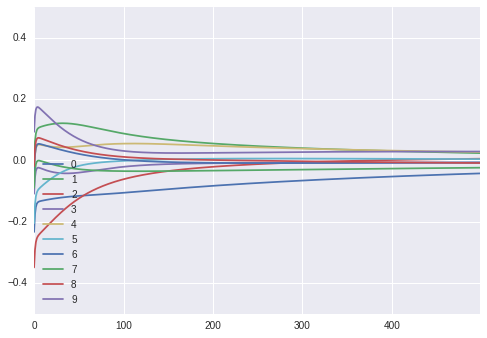

In [5]:
train(df)

In [8]:
predict([[0.1,0.9,0,0], [0.1,0.9,0,1], [0.1,0.9,1,0], [0.1,0.9,1,1]])

array([[ 0.51694048],
       [ 0.51796546],
       [ 0.51504904],
       [ 0.51598904]])

## Network with easily configurable structure

In [70]:
si = lambda x: 1/(1+np.exp(-x))
sd = lambda x: x*(1-x)
features = df.shape[1] - 1
network = [features, 4, 1]   # structure has to start with features and end with 1
alpha = [0.1, 0.1]     # For each synapse
dropout = [0.01]     # For each layer
steps = 500    # number of simulations

S = []
for i in range(len(network) - 1):
    S.append(2*np.random.random((network[i], network[i+1])) - 1)

def train(df):
    global S
    L = list(np.zeros(len(network)))
    d = list(np.zeros(len(network) - 1))
    L[0] = df.ix[:,:-1].values
    Y = df.ix[:,-1].values[np.newaxis].T
    errors = pd.DataFrame(columns = range(L[0].shape[0]))
    for i in range(steps):
        for j in range(len(network) - 1):
            L[j+1] = si(np.dot(L[j], S[j]))
            if j != len(network) - 2:
                L[j+1] *= np.random.binomial([np.ones((L[j+1].shape[0], network[j+1]))],
                                             1 - dropout[j])[0] * (1.0/(1 - dropout[j]))        
        d[-1] = (Y - L[-1]) * sd(L[-1])
        for j in reversed(range(1, len(network) - 1)):
            d[j-1] = np.dot(d[j], S[j].T) * sd(L[j])
        for j in reversed(range(len(network) - 1)):
            S[j] += alpha[j] * np.dot(L[j].T, d[j])
        errors.loc[i] = (Y - L[-1]).T[0]
    errors.plot(ylim = [-0.5,0.5])

def predict(v):
    global S
    ans = si(np.dot(np.array(v), S[0]))
    for i in range(1, len(network) - 1):
        ans = si(np.dot(np.array(ans), S[i]))
    return ans

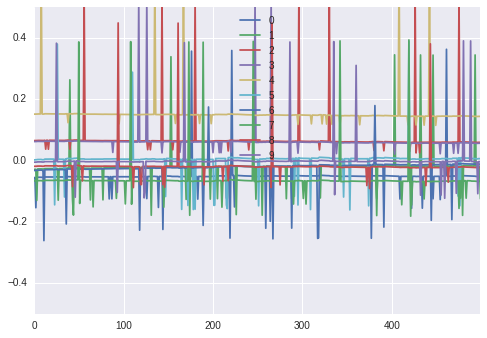

In [75]:
train(df)

In [76]:
predict([[0.1,0.9,0,0], [0.1,0.9,0,1], [0.1,0.9,1,0], [0.1,0.9,1,1]])

array([[ 0.48125411],
       [ 0.60752829],
       [ 0.67790618],
       [ 0.75894111]])